In [80]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [81]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)

X = df.iloc[0:100, [0, 2]].values
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

In [82]:
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            # Eigen Matrix 
            self.w_[1:] += self.eta * X.T.dot(errors)
            # Bias Unit 
            self.w_[0] += self.eta * errors.sum() 
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

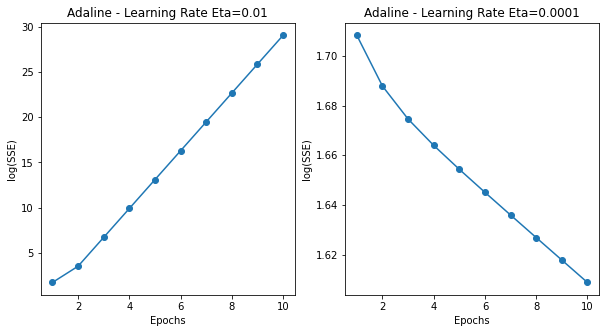

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ada_one = AdalineGD(eta=0.01, n_iter=10).fit(X, y)
# ax[0].plot(range(1, len(ada_one.cost_) + 1), ada_one.cost_, marker='o')
ax[0].plot(range(1, len(ada_one.cost_) + 1), np.log10(ada_one.cost_), marker='o')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log(SSE)")
ax[0].set_title("Adaline - Learning Rate Eta=0.01")

ada_two = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada_two.cost_) + 1), np.log10(ada_two.cost_), marker='o')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("log(SSE)")
ax[1].set_title("Adaline - Learning Rate Eta=0.0001")

plt.show()

# Standardization

In [84]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [85]:
### Draw Decision Region Fn
def decision_region(X, y, classfier, resolution=0.02):
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    Z = classfier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1], 
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl)

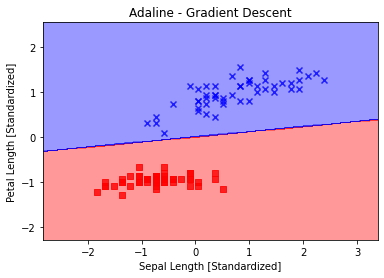

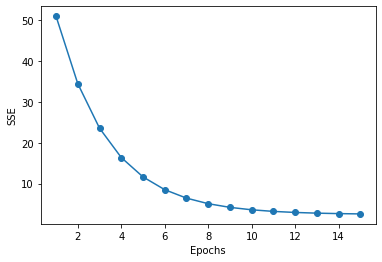

In [87]:
ada_std = AdalineGD(eta=0.01, n_iter=15)
ada_std.fit(X_std, y)

decision_region(X_std, y, classfier=ada_std)
plt.title("Adaline - Gradient Descent")
plt.xlabel("Sepal Length [Standardized]")
plt.ylabel("Petal Length [Standardized]")
plt.show()

plt.plot(range(1, len(ada_std.cost_) + 1), ada_std.cost_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("SSE")
plt.show()

# Adaline With SGD

In [98]:
class AdalineGDSGD(object):
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        # Shuffle Random Environment
        self.shuffle = shuffle
        self.random_state = random_state
    
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self.w_initialized(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
        
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

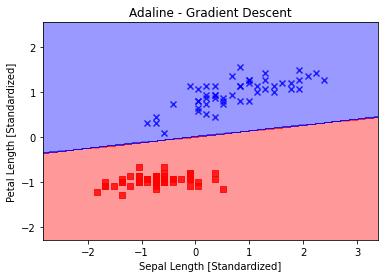

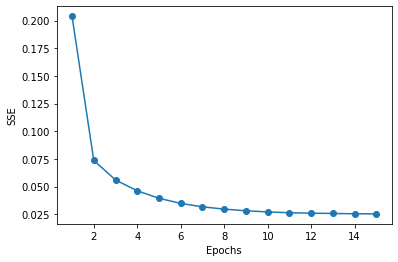

In [99]:
ada_sgd = AdalineGDSGD(eta=0.01, n_iter=15, random_state=1)
ada_sgd.fit(X_std, y)

decision_region(X_std, y, classfier=ada_sgd)
plt.title("Adaline - Gradient Descent")
plt.xlabel("Sepal Length [Standardized]")
plt.ylabel("Petal Length [Standardized]")
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("SSE")
plt.show()